This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [58]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os
from importlib import reload

# Local imports
import sys
sys.path.append('../')
import stlstuff as sls
import imagestuff as ims
import facetbrightnessstuff9 as fbs
import f90nml
import gradstuff as gds
import statstuff as sts
import fourierstuff as fs
import retrievestuff as rs

In [59]:
%matplotlib notebook

In [60]:
# Display parameters
azim=-120
elev=40

In [61]:
# Define the variance in the observations (BS units^2)
noiseamp = 10.0
noisestd = noiseamp**.5
print('Se^.5 is', noisestd)
extranoise = 0
print('Total noise is', noisestd+extranoise)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0
print('Std deviation in a priori is', apriorivar0**.5)

Se^.5 is 3.1622776601683795
Total noise is 3.1622776601683795
Std deviation in a priori is 15.0


In [62]:
# Read and unpack the calibration data
Calibration=f90nml.read('Calibration.nml') #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

In [63]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [64]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes

In [65]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
fbs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [66]:
def create_surface1():
    # Creates a sloped plane; arg is not used
    Truenx = 35; Trueny = 36; dx = dy = 0.66
    Truesolution = np.zeros((Trueny,Truenx))
    slopey = 0.0
    slopex = 0.05
    for ix in range(Truenx):
        for iy in range(Trueny):
            Truesolution[iy,ix] += iy*slopey*dy
    for ix in range(Truenx):
        for iy in range(Trueny):
            Truesolution[iy,ix] += ix*slopex*dx
    #print(np.shape(Truesolution))
    ymax = dy*(Trueny-1)
    xmax = dx*(Truenx-1)
    surf_ytot = np.linspace(0,ymax,Trueny); #print(surf_ytot[1]-surf_ytot[0]); 
    surf_xtot = np.linspace(0,xmax,Truenx); #print(surf_xtot[1]-surf_xtot[0]); 
    surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
    return (Truenx, Trueny, dx, dy, surf_xgridtot, surf_ygridtot, Truesolution)

def create_surface2():
    # Creates a surface based on a bunch of sines and cosines; arg is not used
    Truenx = 35; Trueny = 36; dx = dy = 0.66
    height = 0.25
    ymax = dy*(Trueny-1)
    xmax = dx*(Truenx-1)
    surf_ytot = np.linspace(0,ymax,Trueny); #print(surf_ytot[1]-surf_ytot[0]); 
    surf_xtot = np.linspace(0,xmax,Truenx); #print(surf_xtot[1]-surf_xtot[0]); 
    surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
    lambdax1 = 5; kx1 = np.pi*2/lambdax1
    lambdax2=  7; kx2 = np.pi*2/lambdax2
    lambdax3=  10; kx3 = np.pi*2/lambdax3
    lambday1 = 7; ky1 = np.pi*2/lambday1
    lambday2 = 8; ky2 = np.pi*2/lambday2  
    lambday3 = 9; ky3 = np.pi*2/lambday3  
    term1 = np.cos(kx1*surf_xgridtot) + np.sin(ky1*surf_ygridtot)
    term2 = np.sin(kx2*surf_xgridtot) + np.cos(ky2*surf_ygridtot)
    term3 = np.cos(kx3*(surf_xgridtot+surf_xgridtot) + np.sin(ky3*(surf_ygridtot+surf_xgridtot)))
    Truesolution = (term1*term2+term3)*height
    return (Truenx, Trueny, dx, dy, surf_xgridtot, surf_ygridtot, Truesolution)

def create_surface3():
    # A surface retrieved from observations; arg is used to indicate the segment desired
    flattenedfile = np.load('../crystals/2019-08-02/case1.1/Segments1_compr_flat_filt.npz')
    isegment = 11
    stlfilename = 'Segments1_compr_flat_filt_'+str(isegment)+'_vx5_remade.stl'; print(stlfilename)
    xgridtot = flattenedfile['xgridtot']
    ygridtot = flattenedfile['ygridtot']
    zgridtot = flattenedfile['zgridtot']
    Truesolution = zgridtot[isegment]
    surf_xgridtot = xgridtot[isegment]; dx = surf_xgridtot[0,1]-surf_xgridtot[0,0]; print('dx', dx)
    surf_ygridtot = ygridtot[isegment]; dy = surf_ygridtot[1,0]-surf_ygridtot[0,0]; print('dy', dy)
    Trueny, Truenx = np.shape(Truesolution); print(Truenx, Trueny)
    return (Truenx, Trueny, dx, dy, surf_xgridtot, surf_ygridtot, Truesolution, stlfilename)

Segments1_compr_flat_filt_11_vx5_remade.stl
dx 0.6614583000000067
dy 0.6614583000000014
49 29
std dev of height 0.19002267882436508


<IPython.core.display.Javascript object>


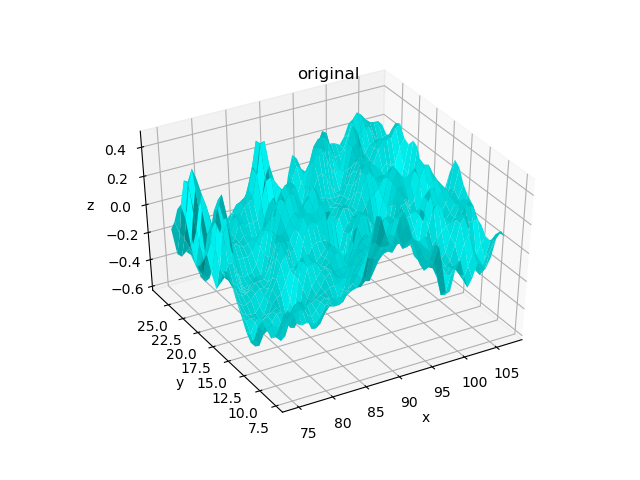

Text(0.5,0.92,'original')

In [67]:
# Make the surface
surfacedata = create_surface3()
Truenx = surfacedata[0]
Trueny = surfacedata[1]
dx = surfacedata[2]
dy = surfacedata[3]
surf_xgridtot = surfacedata[4]
surf_ygridtot = surfacedata[5]
Truesolution = surfacedata[6]

# A little reporting
print('std dev of height', np.std(Truesolution))

# Extract axes
surf_ytot = surf_ygridtot[:,0]; #print(surf_ytot)
surf_xtot = surf_xgridtot[0,:]; #print(surf_xtot)

# Display this surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, Truesolution, color='cyan')
#ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=azim,elev=elev)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
ax.set_title('original')

In [68]:
# Create "observed" backscatter intensities from the forward model

# Get gradients of the true solution
surf_dzgrid_dy_retrieved = np.diff(Truesolution,axis=0)/dy
surf_dzgrid_dx_retrieved = -np.diff(Truesolution,axis=1)/dx

# Generate "observed" backscatter intensities
bigKx = np.matrix(np.empty((4,0)), copy=False)
bigKy = np.matrix(np.empty((4,0)), copy=False)
bigc_last = np.matrix(np.empty((4,0)), copy=False)
for iy in range(Trueny-1):
    for ix in range(Truenx-1):
        dzdx = surf_dzgrid_dx_retrieved[iy,ix]; #print('dzdx =', dzdx)
        dzdy = surf_dzgrid_dy_retrieved[iy,ix]; #print('dzdy =', dzdy)
        nxy_last = np.vstack((dzdx,dzdy))
        K_i, c_last = fbs.getK(nxy_last,
        Arule, Brule, Crule, Drule,
        KAxrule, KAyrule,
        KBxrule, KByrule,
        KCxrule, KCyrule,
        KDxrule, KDyrule)
        bigKx = np.hstack((bigKx,K_i[:,0]))
        bigKy = np.hstack((bigKy,K_i[:,1]))
        bigc_last = np.hstack((bigc_last,c_last))
cA_orig = np.reshape(bigc_last[0],(Trueny-1,Truenx-1))
cB_orig = np.reshape(bigc_last[1],(Trueny-1,Truenx-1))
cC_orig = np.reshape(bigc_last[2],(Trueny-1,Truenx-1))
cD_orig = np.reshape(bigc_last[3],(Trueny-1,Truenx-1))
ny,nx = cA_orig.shape; 
print(ny,nx)

28 48


In [69]:
# Add some noise to the observed signals
cA = cA_orig + np.random.randn(ny,nx)*(noisestd+extranoise)
cB = cB_orig + np.random.randn(ny,nx)*(noisestd+extranoise)
cC = cC_orig + np.random.randn(ny,nx)*(noisestd+extranoise)
cD = cD_orig + np.random.randn(ny,nx)*(noisestd+extranoise)
print(np.std(cA))
print(np.max(cA))
print(np.min(cA))

3.666659051916585
141.2644738764362
119.31188567445511


<IPython.core.display.Javascript object>


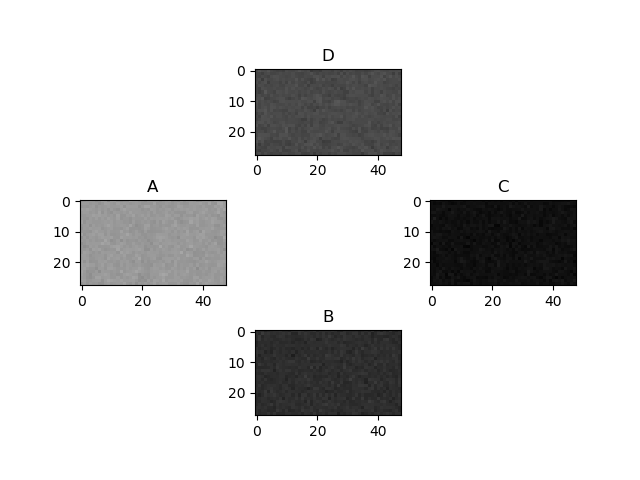

Text(0.5,1,'D')

In [70]:
plt.figure()
vmin = 0; vmax = 255
plt.subplot(334); plt.imshow(np.asarray(cA), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('A')
plt.subplot(338); plt.imshow(np.asarray(cB), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('B')
plt.subplot(336); plt.imshow(np.asarray(cC), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('C')
plt.subplot(332); plt.imshow(np.asarray(cD), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('D')

In [71]:
# What's the random expectation of information content
print('Correlation of random signals =', sts.randomcorrelation(ny,nx)*100)
    
# Loop to evaluate the information content in each segment
print('Correlation of detectors A-D for each segment')
cseg = [cA,cB,cC,cD]
infomatrix = sts.getinfomatrix(cseg)
print('correlation matrix:')
print(infomatrix*100)
print('')

Correlation of random signals = 2.693575390313855
Correlation of detectors A-D for each segment
correlation matrix:
[[100.          -3.39983111 -15.46002824   4.52013723]
 [  0.         100.          -4.2677328   -9.24735066]
 [  0.           0.         100.          -1.33743735]
 [  0.           0.           0.         100.        ]]



In [72]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [73]:
# Generic retrieval parameters
maxiter = 6
tolerance = 10

In [74]:
# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

In [75]:
# Retrieve 

# Construct gradients
Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
Ny = Ny_unscaled/dy
Nx = -Nx_unscaled/dx #fixing x inversion

# Number of observations
nobs = (nx-1)*(ny-1)*4; #print(nobs)

# Number of desired points (heights)
nzpts = ny*nx-1; print(nzpts)

# Extract the a priori variance
vartemp = apriorivar[0:ny,0:nx]
vartemp_long = np.reshape(vartemp,nzpts+1,0)
Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)

# Extract the starting z
settemp = copy.copy(solution)
settemp_long = np.reshape(settemp,nzpts+1,0)
settemp_longminus1 = settemp_long[:-1]
z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
z_start = z_start*0.0; #print "aprioriset", shape(z_start)

# Construct the variance in observation + model
Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

# Do the retrieval
print('')
z_retrieved = fbs.retrievesegment(\
0,0,nx-1,ny-1,cA,cB,cC,cD,\
Sa,Se,z_start,maxiter,tolerance,\
Nx,Ny,\
Arule, Brule, Crule, Drule,\
KAxrule, KAyrule, \
KBxrule, KByrule, \
KCxrule, KCyrule, \
KDxrule, KDyrule)
solution = copy.copy(z_retrieved)

1343

Observed intensities (detector B):
mean, max, min = 38.47542507542714 48.85029610305256 25.216681139387937
<diff>, std(diff), di2 = -0.03553806144459769 3.4878269579108445 2306.9914244622523
<diff>, std(diff), di2 = -0.050072430690686495 2.7664531902273537 15.1893028029594
<diff>, std(diff), di2 = -0.04271744913737547 2.7607966398151196 0.3832551507332427


In [76]:
# Shorten the grids to match the solution
surf_xgrid = surf_xgridtot[0:-1,0:-1]
surf_ygrid = surf_ygridtot[0:-1,0:-1]

# Re-level to match the true solution as closely as possible
shift = np.mean(Truesolution[0:-1,0:-1]-solution); #print(shift)
solution += shift

<IPython.core.display.Javascript object>


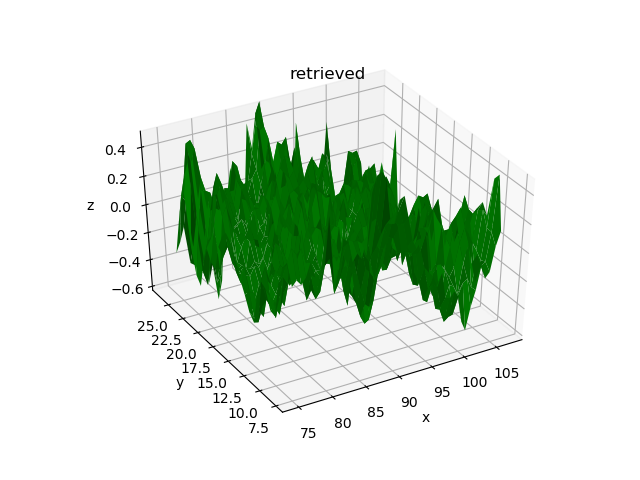

std error = 0.2224119507425465
std dev of height = 0.23302691539889503


In [77]:
# Show the reconstructed surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgrid, surf_ygrid, solution, color='g')
#ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=azim,elev=elev)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
ax.set_title('retrieved')

difference = np.std(solution-Truesolution[0:-1,0:-1]); print('std error =', difference)
variability = np.std(solution); print('std dev of height =', variability)

lambda cutting off at 2.5132741228718345 um
(28, 48)


<IPython.core.display.Javascript object>


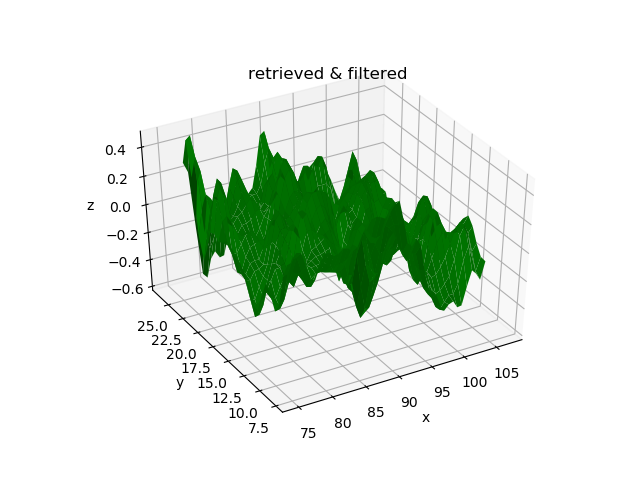

(-0.6069175634667389, 0.48519138619678015)

In [78]:
# Fourier transform & filter

# Set the low-pass threshold
kmax = 2.5
print('lambda cutting off at', np.pi*2/kmax, 'um')

# Do the filtering
solution_filtered = fs.filterseg(kmax,surf_xgrid,surf_ygrid,solution)[0]; print(np.shape(solution_filtered))

# Get rid of the edges
surf_xgrid_truncated = surf_xgrid[1:-2,1:-2]
surf_ygrid_truncated = surf_ygrid[1:-2,1:-2]
Retrsolution = solution_filtered[1:-2,1:-2]

# Graphing the filtered surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgrid_truncated, surf_ygrid_truncated, Retrsolution, color='g')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('retrieved & filtered')
ax.view_init(azim=azim,elev=elev)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

<IPython.core.display.Javascript object>


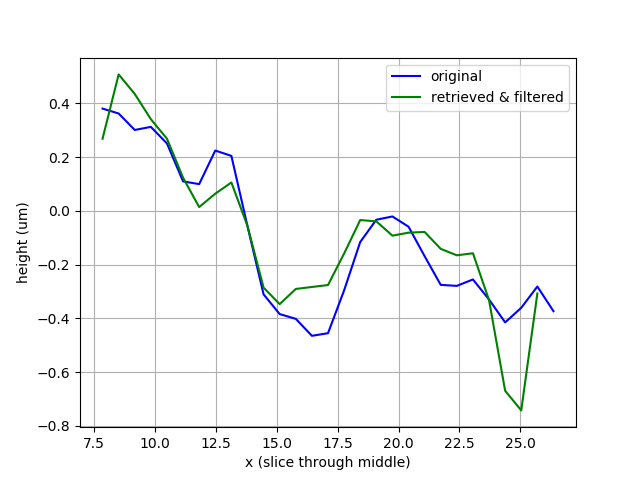

In [79]:
# Show a slice of the reconstructed surface
plt.figure()
midpt = int(nx/2)
shift = np.mean(solution[:,midpt])-np.mean(Truesolution[:,midpt])
plt.plot(surf_ytot,Truesolution[:,midpt]+shift, color='b', label='original')
plt.plot(surf_ytot[0:-1],np.array(solution_filtered[:,midpt]), color='g', label='retrieved & filtered')
plt.xlabel('x (slice through middle)')
plt.ylabel('height (um)')
plt.grid(True)
plt.legend()

Z2 ranging from 0.0 to 0.13
Max number of bins specified is 8
Using levels = 3 for uncertainty analysis
Sturges rule says maxbins = 11
Using nbins =  8
Original =  1344
4 0 336 [178  74  32  19  11  10   2]
4 1 336 [163  79  38  20  11   5   6]
4 2 336 [181  70  32  21  10   4   6]
4 3 336 [184  70  36  16   9   5   6]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
True meanZ2 =  0.03109153754663716
True statsigma =  0.1763279261678001
integral =  0.01337772397094431
Original =  1056
4 0 264 [108  53  35  23  14  12   4]
4 1 264 [101  64  40  21  14   6   5]
4 2 264 [115  58  37  20  13   5   5]
4 3 264 [101  65  39  22  14   9   5]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
Retr meanZ2 =  0.04154896525021312
Retr statsigma =  0.20383563292568138
integral =  0.014481292517006802


<IPython.core.display.Javascript object>


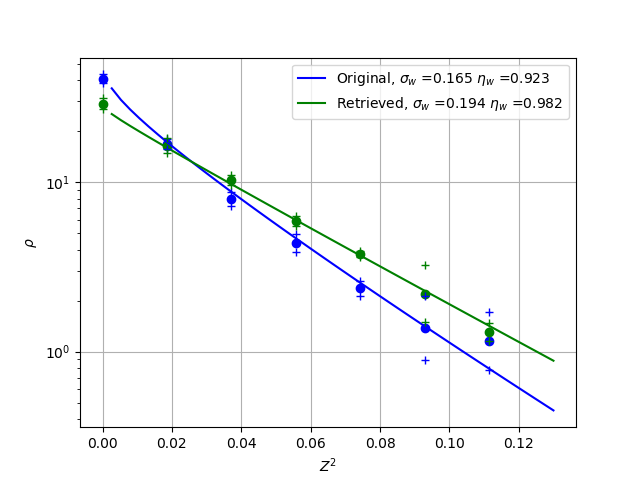

Based on bins: sigmaW, etaW of original =  0.16588196972996128 0.9231139951314764
Based on bins: sigmaW, etaW of retrieved/filtered =  0.1946690435381096 0.9826591781551305


In [80]:
# Get the probability distributions in Z2

# Parameters
Z2minforhist = 0.0; Z2maxforhist = .13; print('Z2 ranging from', Z2minforhist, 'to', Z2maxforhist)
Z2offset = 0.001
nbins_max = 8; print('Max number of bins specified is', nbins_max)
levels = 3; print('Using levels =', levels, 'for uncertainty analysis')
Ntot = np.size(Truesolution)
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says maxbins =', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2bins = np.linspace(Z2minforhist,Z2maxforhist,nbins); #print(Z2bins)
Z2theory = np.linspace(Z2minforhist,Z2maxforhist,50); Z2theory=Z2theory[1:] # This is for Weibull plots
x0 = np.array([.1,.9])

# Get the probability for the original
Truecounts, bins, TruemeanZ2, TrueZ2flat, Trueerror = rs.getrhoofz2(Truesolution,dx,dy,Z2bins=Z2bins,levels=levels)
print('True meanZ2 = ', TruemeanZ2)
print('True statsigma = ', np.sqrt(TruemeanZ2))
Trueintegral_rho = np.trapz(Truecounts, bins); print('integral = ', Trueintegral_rho)
Truecounts = Truecounts/Trueintegral_rho
Trueerror = Trueerror/Trueintegral_rho
Truecountsplus = Truecounts+Trueerror; 
Truecountsminus = Truecounts**2/Truecountsplus; 

# Get the probability for the retrieved
Retrcounts, bins, RetrmeanZ2, RetrZ2flat, Retrerror = rs.getrhoofz2(Retrsolution,dx,dy,Z2bins=Z2bins,levels=levels)
print('Retr meanZ2 = ', RetrmeanZ2)
print('Retr statsigma = ', np.sqrt(RetrmeanZ2))
Retrintegral_rho = np.trapz(Retrcounts, bins); print('integral = ', Retrintegral_rho)
Retrcounts = Retrcounts/Retrintegral_rho
Retrerror = Retrerror/Retrintegral_rho
Retrcountsplus = Retrcounts+Retrerror; 
Retrcountsminus = Retrcounts**2/Retrcountsplus; 

# Graph the probabilities
plt.figure()
plt.semilogy(bins, Truecounts, 'ob')
plt.semilogy(bins, Retrcounts, 'og')

# Attempt a best-fit based on the bins for the original
Trueerrors = np.log(Truecountsplus/Truecounts); #print(errors)
Truesol, Truesolerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(Truecounts),x0,sigma=Trueerrors)
TrueetaW = Truesol[1]
Truesigma2W = Truesol[0]
TruesigmaW = np.sqrt(Truesigma2W)
print('Based on bins: sigmaW, etaW of original = ', TruesigmaW, TrueetaW)

# Attempt a best-fit based on the bins for the original
Retrerrors = np.log(Retrcountsplus/Retrcounts); #print(errors)
Retrsol, Retrsolerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(Retrcounts),x0,sigma=Retrerrors)
RetretaW = Retrsol[1]
Retrsigma2W = Retrsol[0]
RetrsigmaW = np.sqrt(Retrsigma2W)
print('Based on bins: sigmaW, etaW of retrieved/filtered = ', RetrsigmaW, RetretaW)

# Graph the best-fit probability
myWeibull = sts.Weibull(Z2theory,Truesigma2W,TrueetaW)
plt.semilogy(Z2theory, myWeibull, 'b',label = 'Original, $\sigma_w$ =' + str(TruesigmaW)[0:5] + ' $\eta_w$ =' + str(TrueetaW)[0:5])

# Graph the best-fit probability
myWeibull = sts.Weibull(Z2theory,Retrsigma2W,RetretaW)
plt.semilogy(Z2theory, myWeibull, 'g',label = 'Retrieved, $\sigma_w$ =' + str(RetrsigmaW)[0:5] + ' $\eta_w$ =' + str(RetretaW)[0:5])

# Add the error bars
plt.semilogy(bins, Truecountsplus, '+b')
plt.semilogy(bins, Truecountsminus,'+b')
plt.semilogy(bins, Retrcountsplus, '+g')
plt.semilogy(bins, Retrcountsminus,'+g')

# Labels, etc
plt.xlabel(r'$Z^{2}$')
plt.ylabel(r'$\rho$')
plt.grid(True)
plt.legend()


In [81]:
# Save an image
fig.savefig('benchmark.jpg')

# Save stl files
vscale = 5
stlfilename = surfacedata[7]; print(stlfilename)
#sls.numpy2stl(np.fliplr(sollast_FT_filtered_IFT_real[1:-2,1:-2]), stlfilename, scale=vscale/dx, solid=False)
sls.numpy2stl(Retrsolution, stlfilename, scale=vscale/dx, solid=False)

Segments1_compr_flat_filt_11_vx5_remade.stl
Creating top mesh...


In [82]:
# Compressedfilename = 'benchmarkretrieved.npz'
# print("saving", Compressedfilename)
# np.savez_compressed(Compressedfilename, \
#                     surfaceroot='2018', \
#                     imageroot='2018', \
#                     nx1list=[0], \
#                     nx2list=[nx-1], \
#                     ny1list=[0], \
#                     ny2list=[ny-1], \
#                     pA=pA, \
#                     pB=pB, \
#                     pC=pC, \
#                     pD=pD, \
#                     sA=sA, \
#                     sB=sB, \
#                     sC=sC, \
#                     sD=sD, \
#                     nxi=nxi, \
#                     nyi=nyi, \
#                     dnx=dnx, \
#                     dny=dny, \
#                     solution=solution)

In [83]:
# # More attempts to understand how the FT works
# import fourierstuff as fs
# x = np.linspace(0,20,50)
# y = np.linspace(0,20,51)
# xgrid,ygrid = np.meshgrid(x,y)
# lambdax = 5; kx = np.pi*2/lambdax; print(kx)
# lambday = 4; ky = np.pi*2/lambday; print(ky)
# sollast = np.sin(kx*xgrid) + np.sin(ky*ygrid)
# Ny, Nx = np.shape(sollast)

# # FT
# sollast_FTshift,kxshift,kyshift = fs.FT(sollast,x,y)
# kxshiftgrid,kyshiftgrid = np.meshgrid(kxshift,kyshift);
# sollast_FTshift_square = np.real(sollast_FTshift)**2 +  np.imag(sollast_FTshift)**2 


# # Plotting
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(xgrid, ygrid, sollast)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('original')

# plt.figure()
# plt.contour(kxshiftgrid, kyshiftgrid, sollast_FTshift_square)
# plt.xlabel('kx')
# plt.ylabel('ky')
# plt.title('Power spectrum')
# plt.grid(True)
